In [1]:

# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES
# TO THE CORRECT LOCATION (/kaggle/input) IN YOUR NOTEBOOK,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.

import os
import sys
from tempfile import NamedTemporaryFile
from urllib.request import urlopen
from urllib.parse import unquote, urlparse
from urllib.error import HTTPError
from zipfile import ZipFile
import tarfile
import shutil

CHUNK_SIZE = 40960
DATA_SOURCE_MAPPING = 'sarcasm:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F1309%2F36545%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240510%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240510T231911Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D072a5b08c42a0ee5ef49bd490e63f2e60b34af05b2cc07bc17013d7608686c3521d1f72dd3252cadf7b3480e29d4e6c18e40d3ca0617bfd7e4c362fdb9935a737303ec5a123fb1392634201b25eeedcce823bd43836b8e55c7172e016b58f5aeb0b8d22239d9d2b237ce00a0ada93e84d6d2e09a3a94e4f8f5f9f51128fb9c183bc42f065f6dac3d8b38abadac63c55a113acd0ab43c7baedf66c7d57cca913ebded27f5b82578f22db666dd90f849144abfdbbb2cbe8207093f2eb3e05265cdb961386d989b1ab62886e1742260fa173c4a6f58df1d935f99f44f779b1493de8743d827777c63c0e691e10a43cf89203626c98349c84beefe72d1920cdb2d52'

KAGGLE_INPUT_PATH='/kaggle/input'
KAGGLE_WORKING_PATH='/kaggle/working'
KAGGLE_SYMLINK='kaggle'

!umount /kaggle/input/ 2> /dev/null
shutil.rmtree('/kaggle/input', ignore_errors=True)
os.makedirs(KAGGLE_INPUT_PATH, 0o777, exist_ok=True)
os.makedirs(KAGGLE_WORKING_PATH, 0o777, exist_ok=True)

try:
  os.symlink(KAGGLE_INPUT_PATH, os.path.join("..", 'input'), target_is_directory=True)
except FileExistsError:
  pass
try:
  os.symlink(KAGGLE_WORKING_PATH, os.path.join("..", 'working'), target_is_directory=True)
except FileExistsError:
  pass

for data_source_mapping in DATA_SOURCE_MAPPING.split(','):
    directory, download_url_encoded = data_source_mapping.split(':')
    download_url = unquote(download_url_encoded)
    filename = urlparse(download_url).path
    destination_path = os.path.join(KAGGLE_INPUT_PATH, directory)
    try:
        with urlopen(download_url) as fileres, NamedTemporaryFile() as tfile:
            total_length = fileres.headers['content-length']
            print(f'Downloading {directory}, {total_length} bytes compressed')
            dl = 0
            data = fileres.read(CHUNK_SIZE)
            while len(data) > 0:
                dl += len(data)
                tfile.write(data)
                done = int(50 * dl / int(total_length))
                sys.stdout.write(f"\r[{'=' * done}{' ' * (50-done)}] {dl} bytes downloaded")
                sys.stdout.flush()
                data = fileres.read(CHUNK_SIZE)
            if filename.endswith('.zip'):
              with ZipFile(tfile) as zfile:
                zfile.extractall(destination_path)
            else:
              with tarfile.open(tfile.name) as tarfile:
                tarfile.extractall(destination_path)
            print(f'\nDownloaded and uncompressed: {directory}')
    except HTTPError as e:
        print(f'Failed to load (likely expired) {download_url} to path {destination_path}')
        continue
    except OSError as e:
        print(f'Failed to load {download_url} to path {destination_path}')
        continue

print('Data source import complete.')


[==================================================] 226798960 bytes downloaded
Downloaded and uncompressed: sarcasm
Data source import complete.


In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All"
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/sarcasm/test-unbalanced.csv
/kaggle/input/sarcasm/train-balanced-sarc.csv.gz
/kaggle/input/sarcasm/train-balanced-sarcasm.csv
/kaggle/input/sarcasm/test-balanced.csv


In [3]:
import tensorflow as tf
import tensorflow_hub as hub
import matplotlib.pyplot as plt

In [4]:
# avoid oom erors

gpus = tf.config.experimental.list_physical_devices('GPU')

for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu,True)

In [5]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [6]:
df_train = pd.read_csv('/kaggle/input/sarcasm/train-balanced-sarcasm.csv')
df_train.head()

,label,comment,author,subreddit,score,ups,downs,date,created_utc,parent_comment
0,0,NC and NH.,Trumpbart,politics,2,-1,-1,2016-10,2016-10-16 23:55:23,"Yeah, I get that argument. At this point, I'd ..."
1,0,You do know west teams play against west teams...,Shbshb906,nba,-4,-1,-1,2016-11,2016-11-01 00:24:10,The blazers and Mavericks (The wests 5 and 6 s...
2,0,"They were underdogs earlier today, but since G...",Creepeth,nfl,3,3,0,2016-09,2016-09-22 21:45:37,They're favored to win.
3,0,"This meme isn't funny none of the ""new york ni...",icebrotha,BlackPeopleTwitter,-8,-1,-1,2016-10,2016-10-18 21:03:47,deadass don't kill my buzz
4,0,I could use one of those tools.,cush2push,MaddenUltimateTeam,6,-1,-1,2016-12,2016-12-30 17:00:13,Yep can confirm I saw the tool they use for th...


In [7]:
len(df_train)

1010826

In [8]:
df_train.isnull().sum()

label              0
comment           55
author             0
subreddit          0
score              0
ups                0
downs              0
date               0
created_utc        0
parent_comment     0
dtype: int64

In [9]:
df_train = df_train.dropna(subset=['comment'])
df_train.isnull().sum()

label             0
comment           0
author            0
subreddit         0
score             0
ups               0
downs             0
date              0
created_utc       0
parent_comment    0
dtype: int64

In [10]:
len(df_train)

1010771

In [11]:
len(df_train['subreddit'].unique())

14876

In [12]:
df_train['comment'] = df_train['comment'].astype(str)

In [13]:
# doing univariate (using comments only, and no context)



In [14]:
from sklearn.model_selection import train_test_split

# # First, split the data into 80% train and 20% temp (which will later be split into validation and test)
# X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.2, random_state=5)

# # Now, split the temporary data (X_temp, y_temp) into 50% validation and 50% test
# X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=5)

# print("Train set size:", len(X_train))
# print("Validation set size:", len(X_val))
# print("Test set size:", len(X_test))

In [15]:
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem.porter import PorterStemmer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

In [16]:
# https://www.tensorflow.org/tutorials/structured_data/preprocessing_layers

# pipelining

def df_to_dataset(dataframe, shuffle=True, batch_size=1024):
    df = dataframe.copy()
    labels = df.pop('label')
    df = df['comment']
    ds = tf.data.Dataset.from_tensor_slices((df, labels))
    if shuffle:
        ds = ds.shuffle(buffer_size=len(dataframe))
    ds = ds.batch(batch_size)
    ds = ds.prefetch(tf.data.AUTOTUNE)
    return ds

In [17]:
import re

def decontractions(phrase):
    """decontracted takes text and convert contractions into natural form.
     ref: https://stackoverflow.com/questions/19790188/expanding-english-language-contractions-in-python/47091490#47091490"""
    # specific
    phrase = re.sub(r"won\'t", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)
    phrase = re.sub(r"won\’t", "will not", phrase)
    phrase = re.sub(r"can\’t", "can not", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)

    phrase = re.sub(r"n\’t", " not", phrase)
    phrase = re.sub(r"\’re", " are", phrase)
    phrase = re.sub(r"\’s", " is", phrase)
    phrase = re.sub(r"\’d", " would", phrase)
    phrase = re.sub(r"\’ll", " will", phrase)
    phrase = re.sub(r"\’t", " not", phrase)
    phrase = re.sub(r"\’ve", " have", phrase)
    phrase = re.sub(r"\’m", " am", phrase)

    return phrase

In [18]:
# Remove Emoji
# def deEmojify(text):
#     regrex_pattern = re.compile(pattern = "["
#         u"\U0001F600-\U0001F64F"  # emoticons
#         u"\U0001F300-\U0001F5FF"  # symbols & pictographs
#         u"\U0001F680-\U0001F6FF"  # transport & map symbols
#         u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
#                            "]+", flags = re.UNICODE)
#     return regrex_pattern.sub(r'',text)

In [19]:
# # stemming the comments
# from tqdm import tqdm
# stemmer = PorterStemmer()

# def preprocess(text_col, stopword):
#     preprocessed = []
#     for sentence in tqdm(text_col.values):
#         # Replace escape characters with spaces
#         sentence = str(sentence)
#         sent = sentence.replace('\\r', ' ').replace('\\"', ' ').replace('\\n', ' ')
#         # Replace non-alphanumeric characters with spaces
#         sent = re.sub('[^A-Za-z0-9]+', ' ', sent)
#         # Decontraction and emoji removal functions
#         sent = decontractions(sent)
#         sent = deEmojify(sent)
#         # Tokenize sentence
#         tokens = sent.split()
#         if stopword:
#             # Remove stopwords and stem words
#             sent = ' '.join(stemmer.stem(e) for e in tokens if e.lower() not in stopwords)
#         else:
#             # Stem words
#             sent = ' '.join(stemmer.stem(e) for e in tokens)
#         # Convert to lowercase and strip whitespace
#         preprocessed.append(sent.lower().strip())
#     return preprocessed

In [20]:
df_train = df_train[["comment", "label"]]
df_train.head()

,comment,label
0,NC and NH.,0
1,You do know west teams play against west teams...,0
2,"They were underdogs earlier today, but since G...",0
3,"This meme isn't funny none of the ""new york ni...",0
4,I could use one of those tools.,0


In [21]:
df_train["comment"] = df_train["comment"].apply(decontractions)

In [22]:
# trim the datset over here

#df_train = df_train[:200000]

In [23]:
train, val, test = np.split(df_train.sample(frac=1), [int(0.6 * len(df_train)), int(0.9 * len(df_train))])

In [24]:
len(train), len(val), len(test)

(606462, 303231, 101078)

In [25]:
train_data = df_to_dataset(train)
val_data = df_to_dataset(val)
test_data = df_to_dataset(test)


In [26]:
len(train_data)

593

In [27]:
# for feeding in logistic regressionmodel

X_train = train['comment']
y_train = train['label']

X_val = val['comment']
y_val = val['label']

X_test = test['comment']
y_test = test['label']

In [28]:
vectorizer = TfidfVectorizer(max_features=2000)

In [29]:
X_train = vectorizer.fit_transform(X_train)
X_val = vectorizer.transform(X_val)
X_test = vectorizer.transform(X_test)

In [36]:
print(X_train)



  (0, 217)	0.5536999768971492
  (0, 1952)	0.3896624809614743
  (0, 1777)	0.33655963535641686
  (0, 1901)	0.33670052012924484
  (0, 200)	0.3708176226059638
  (0, 1739)	0.14224606144452068
  (0, 467)	0.39648481292084753
  (1, 1356)	0.3072258882445656
  (1, 672)	0.35279925519077737
  (1, 1938)	0.20002552620973574
  (1, 1737)	0.13812291259835838
  (1, 1696)	0.23669699768600846
  (1, 85)	0.20647505331140178
  (1, 594)	0.39072465354505437
  (1, 1844)	0.2234100050361088
  (1, 1379)	0.28732293738286785
  (1, 1030)	0.3852164621994276
  (1, 1179)	0.25157144278227717
  (1, 1992)	0.13452379401242173
  (1, 1777)	0.25154996203939045
  (1, 1739)	0.2126338847421725
  (3, 1014)	0.5390942864888622
  (3, 1620)	0.8422454216409044
  (4, 997)	0.2968023703746974
  (4, 1570)	0.2671562550827991
  :	:
  (606460, 1516)	0.1887517003624999
  (606460, 285)	0.1500609106969755
  (606460, 275)	0.18284544414685566
  (606460, 1947)	0.14412786392076313
  (606460, 495)	0.13784264168655833
  (606460, 1202)	0.22462524849386

# Logistic regression

In [49]:

from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression

In [38]:
model_logistic = LogisticRegression(max_iter=1000)

In [39]:
model_logistic.fit(X_train,y_train)

LogisticRegression(max_iter=1000)

In [41]:
# accuracy of logistic regression
from sklearn.metrics import accuracy_score, precision_score, recall_score,f1_score

X_train_pred = model_logistic.predict(X_train)

training_acuracy = accuracy_score(y_train,X_train_pred)

testing_accuracy = accuracy_score(y_val,model_logistic.predict(X_val))
f1_score = f1_score(y_val,model_logistic.predict(X_val))

print(f"training accuracy: {training_acuracy}")
print(f"testing accuracy: {testing_accuracy}")
print(f"f1 score: {f1_score}")

training accuracy: 0.6773103673437083
testing accuracy: 0.6734601673311765
f1 score: 0.6562399102905488


In [ ]:
#####################################################################################################
#####################################################################################################
#####################################################################################################
# K corss validation for the logistic regressionmodel


In [41]:
df_train.head()

,comment,label
0,NC and NH.,0
1,You do know west teams play against west teams...,0
2,"They were underdogs earlier today, but since G...",0
3,"This meme is not funny none of the ""new york n...",0
4,I could use one of those tools.,0


In [50]:
from sklearn.model_selection import StratifiedKFold

k = 5
skf = StratifiedKFold(n_splits=k, shuffle=True, random_state=42)

log_reg_model = LogisticRegression(max_iter=1000)

accuracy_scores = []

In [51]:
X_train_kfold = df_train["comment"]
y_train_kfold = df_train["label"]

In [52]:
for train_index, test_index in skf.split(X_train, y_train):
    # Split data into train and test sets for this fold
    X_train_fold, X_test_fold = X_train[train_index], X_train[test_index]
    y_train_fold, y_test_fold = y_train.iloc[train_index], y_train.iloc[test_index]


    log_reg_model.fit(X_train_fold, y_train_fold)

    y_pred_fold = log_reg_model.predict(X_test_fold)


    accuracy_fold = accuracy_score(y_test_fold, y_pred_fold)
    accuracy_scores.append(accuracy_fold)


mean_accuracy = np.mean(accuracy_scores)
print("Mean Accuracy:", mean_accuracy)

Mean Accuracy: 0.6747479617778116


In [53]:
accuracy_scores

[0.6754305689528662,
 0.6756696594197522,
 0.6740428057909837,
 0.6733585067440556,
 0.6752382679814003]

# model + embeddings

In [ ]:
embedding = "https://tfhub.dev/google/nnlm-en-dim50/2"

In [ ]:
hub_layer = hub.KerasLayer(embedding, dtype=tf.string, trainable=True )

In [ ]:
hub_layer(list(train_data)[0][0])

<tf.Tensor: shape=(1024, 50), dtype=float32, numpy=
array([[ 0.18246716, -0.25045478,  0.01416189, ...,  0.06198003,
         0.01614186,  0.0425407 ],
       [ 0.44201636,  0.15413228, -0.20271471, ..., -0.23473515,
        -0.07454342, -0.01310865],
       [ 0.35056347,  0.16880813,  0.20556791, ..., -0.26405996,
         0.02820336, -0.0563311 ],
       ...,
       [ 0.43481627,  0.01296454, -0.19997565, ..., -0.2563704 ,
        -0.0520183 ,  0.13671932],
       [-0.07132284,  0.10488506, -0.14708492, ...,  0.01891405,
         0.05406836,  0.10656393],
       [ 0.24835415,  0.01085313,  0.36698967, ..., -0.00445017,
         0.24759448,  0.00708591]], dtype=float32)>

In [ ]:
model = tf.keras.Sequential()
model.add(hub_layer)
model.add(tf.keras.layers.Dense(16,activation='relu'))
model.add(tf.keras.layers.Dropout(0.4))
model.add(tf.keras.layers.Dense(16,activation='relu'))
model.add(tf.keras.layers.Dropout(0.4))
model.add(tf.keras.layers.Dense(1,activation='sigmoid'))

In [ ]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=['accuracy'])

In [ ]:
# evaluating the untrained model on train data

model.evaluate(train_data)

790/790 [==============================] - 8s 7ms/step - loss: 0.6972 - accuracy: 0.5041


[0.6971532106399536, 0.5041379332542419]

In [ ]:

model.evaluate(val_data)

99/99 [==============================] - 1s 5ms/step - loss: 0.6976 - accuracy: 0.5031


[0.6976189017295837, 0.5030521154403687]

In [ ]:
history = model.fit(train_data,epochs=30,validation_data=val_data)

Epoch 1/30
 27/790 [>.............................] - ETA: 15:58 - loss: 0.6952 - accuracy: 0.5144

KeyboardInterrupt: 

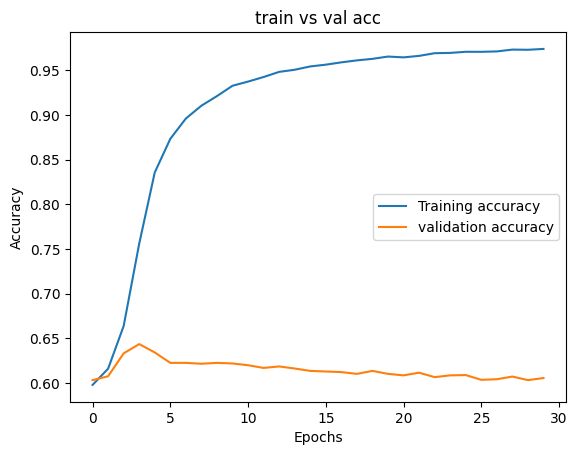

In [ ]:
plt.plot(history.history['accuracy'], label="Training accuracy")
plt.plot(history.history['val_accuracy'], label="validation accuracy")
plt.title("train vs val acc")
plt.ylabel("Accuracy")
plt.xlabel("Epochs")
plt.legend()
plt.show()

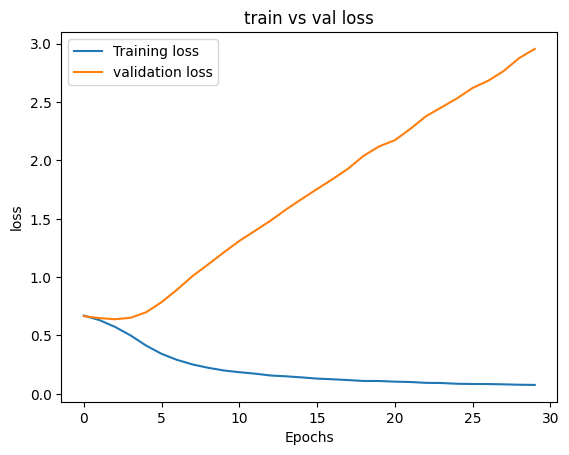

In [ ]:
plt.plot(history.history['loss'], label="Training loss")
plt.plot(history.history['val_loss'], label="validation loss")
plt.title("train vs val loss")
plt.ylabel("loss")
plt.xlabel("Epochs")
plt.legend()
plt.show()

In [ ]:
model.evaluate(test_data)

3/3 [==============================] - 0s 34ms/step - loss: 2.7828 - accuracy: 0.6087


[2.78275465965271, 0.6086666584014893]

# RNN / LSTM

In [30]:
encoder = tf.keras.layers.TextVectorization(max_tokens=2000) # max words to remember
encoder.adapt(train_data.map(lambda text,label:text))

In [31]:
vocab = np.array(encoder.get_vocabulary())
vocab[:30]

array(['', '[UNK]', 'the', 'is', 'a', 'to', 'i', 'you', 'not', 'it',
       'and', 'that', 'of', 'in', 'are', 'for', 'have', 'but', 'they',
       'this', 'be', 'do', 'on', 'he', 'so', 'just', 'was', 'with',
       'like', 'if'], dtype='<U13')

In [ ]:
len(vocab)

2000

In [ ]:
from tensorflow.keras import regularizers

In [ ]:
model2 = tf.keras.Sequential([
    encoder,
    tf.keras.layers.Embedding(
        input_dim=len(encoder.get_vocabulary()),
        output_dim = 128,
        mask_zero=True
    ),
    # tf.keras.layers.LSTM(64,return_sequences=True),
    # tf.keras.layers.Dropout(0.4),
    tf.keras.layers.LSTM(128),
    tf.keras.layers.Dropout(0.4),

    # usually more dense layers are added with more nodes rather than lstm. also consider bi lstm
    tf.keras.layers.Dense(128,activation='relu',kernel_regularizer=regularizers.l2(0.001)),
    tf.keras.layers.Dense(64,activation='relu',kernel_regularizer=regularizers.l2(0.001)),
    tf.keras.layers.Dense(32,activation='relu',kernel_regularizer=regularizers.l2(0.001)),
    tf.keras.layers.Dense(16,activation='relu',kernel_regularizer=regularizers.l2(0.001)),

    tf.keras.layers.Dense(8,activation='relu',kernel_regularizer=regularizers.l2(0.001)),
    tf.keras.layers.Dense(1,activation='sigmoid')


]

)

In [ ]:
model2.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_vectorization (TextVe  (None, None)              0         
 ctorization)                                                    
                                                                 
 embedding_1 (Embedding)     (None, None, 128)         256000    
                                                                 
 lstm_1 (LSTM)               (None, 128)               131584    
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_6 (Dense)             (None, 128)               16512     
                                                                 
 dense_7 (Dense)             (None, 64)                8256      
                                                      

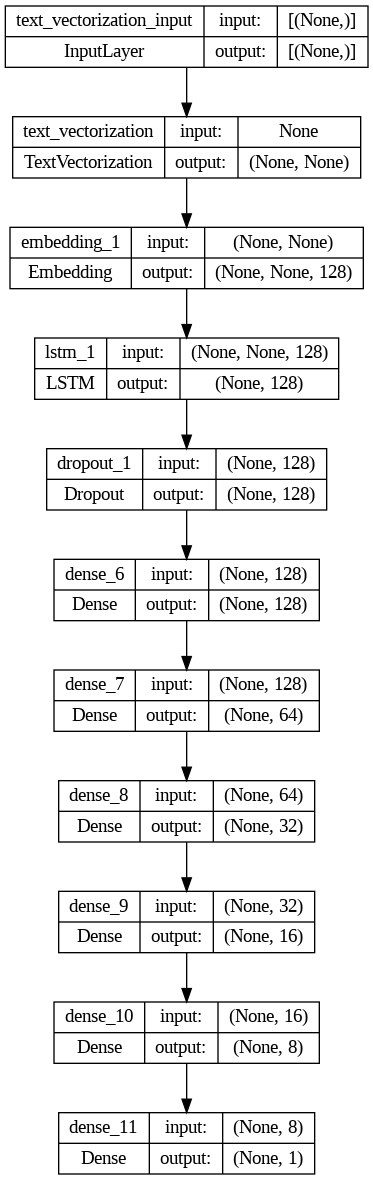

In [ ]:
tf.keras.utils.plot_model(
    model2, to_file='model.png', show_shapes=True, show_layer_names=True,
    rankdir='TB')

In [ ]:
model2.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=['accuracy'])

In [ ]:
model2.evaluate(train_data)

In [ ]:
model2.evaluate(val_data)

297/297 [==============================] - 13s 41ms/step - loss: 0.6931 - accuracy: 0.4995


[0.6931368708610535, 0.4995465576648712]

In [ ]:
history2 = model2.fit(train_data,epochs=15,validation_data=val_data)

Epoch 1/15
593/593 [==============================] - 93s 146ms/step - loss: 0.6354 - accuracy: 0.6803 - val_loss: 0.5820 - val_accuracy: 0.7007
Epoch 2/15
593/593 [==============================] - 80s 133ms/step - loss: 0.5926 - accuracy: 0.6894 - val_loss: 0.5971 - val_accuracy: 0.6872
Epoch 3/15
593/593 [==============================] - 84s 140ms/step - loss: 0.5914 - accuracy: 0.6910 - val_loss: 0.5844 - val_accuracy: 0.6961
Epoch 4/15
593/593 [==============================] - 79s 131ms/step - loss: 0.5808 - accuracy: 0.6992 - val_loss: 0.5770 - val_accuracy: 0.7019
Epoch 5/15
593/593 [==============================] - 80s 133ms/step - loss: 0.5736 - accuracy: 0.7041 - val_loss: 0.5730 - val_accuracy: 0.7051
Epoch 6/15
593/593 [==============================] - 82s 137ms/step - loss: 0.5697 - accuracy: 0.7065 - val_loss: 0.5711 - val_accuracy: 0.7050
Epoch 7/15
593/593 [==============================] - 81s 136ms/step - loss: 0.5670 - accuracy: 0.7080 - val_loss: 0.5733 - val_ac

KeyboardInterrupt: 

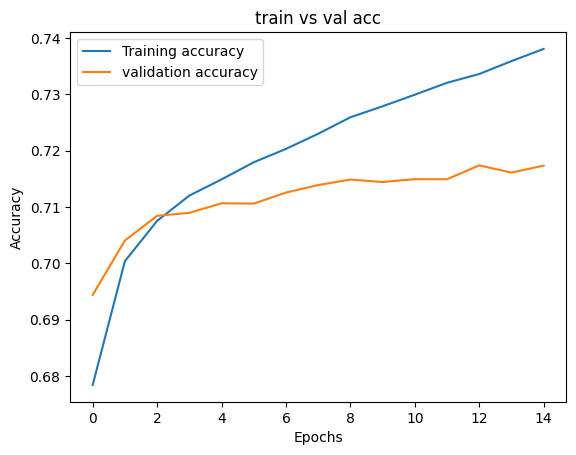

In [ ]:
plt.plot(history2.history['accuracy'], label="Training accuracy")
plt.plot(history2.history['val_accuracy'], label="validation accuracy")
plt.title("train vs val acc")
plt.ylabel("Accuracy")
plt.xlabel("Epochs")
plt.legend()
plt.show()

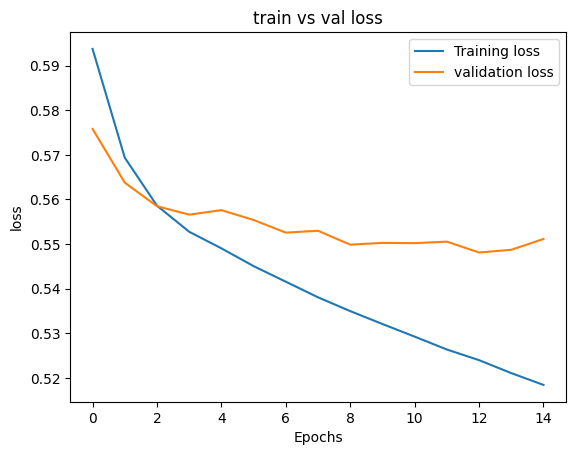

In [ ]:
plt.plot(history2.history['loss'], label="Training loss")
plt.plot(history2.history['val_loss'], label="validation loss")
plt.title("train vs val loss")
plt.ylabel("loss")
plt.xlabel("Epochs")
plt.legend()
plt.show()

In [ ]:
model2.evaluate(test_data)

99/99 [==============================] - 2s 22ms/step - loss: 0.5514 - accuracy: 0.7171


[0.5513665080070496, 0.7170501947402954]

In [ ]:
from sklearn.metrics import confusion_matrix

test.head()

,comment,label
925569,"I know right, it is like a $1000 cabinet",1
225678,Ozil should join Juventus.,0
322071,Yeah because 70k = life,0
576719,But taco is,1
416158,Thats good idea.,1


In [ ]:
true_labels = test['label']

In [ ]:
predictions = model2.predict(test['comment'])

3159/3159 [==============================] - 12s 3ms/step


In [ ]:
predictions[:10]

array([[0.62531024],
       [0.66138524],
       [0.92130953],
       [0.70957583],
       [0.5268054 ],
       [0.5655585 ],
       [0.5045502 ],
       [0.951853  ],
       [0.75885975],
       [0.16952114]], dtype=float32)

In [ ]:
threshold = 0.5

binary_predictions = [1 if pred > threshold else 0 for pred in predictions]
binary_predictions[:10]

[1, 1, 1, 1, 1, 1, 1, 1, 1, 0]

In [ ]:
cm = confusion_matrix(true_labels, binary_predictions)

In [ ]:
cm

array([[39891, 10671],
       [17931, 32585]])

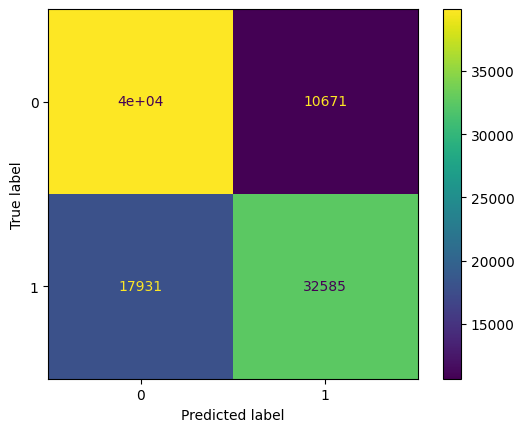

In [ ]:
from sklearn.metrics import ConfusionMatrixDisplay

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0, 1])
disp.plot()

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score,f1_score


accuracy = accuracy_score(true_labels, binary_predictions)
precision = precision_score(true_labels, binary_predictions)
recall = recall_score(true_labels, binary_predictions)
f1score = f1_score(true_labels, binary_predictions)

print(f"Accuracy = {accuracy.round(4)}")
print(f"Precision = {precision.round(4)}")
print(f"Recall = {recall.round(4)}")
print(f"F1 Score = {f1score.round(4)}")

Accuracy = 0.717
Precision = 0.7533
Recall = 0.645
F1 Score = 0.695


# Bi LSTM

In [35]:
from tensorflow.keras.layers import Bidirectional, LSTM, Dropout, Dense, Masking, TimeDistributed
from tensorflow.keras import regularizers

model3 = tf.keras.Sequential([
    encoder,
    tf.keras.layers.Embedding(
        input_dim=len(encoder.get_vocabulary()),
        output_dim = 128,
        mask_zero=True
    ),
    # tf.keras.layers.LSTM(64,return_sequences=True),
    # tf.keras.layers.Dropout(0.4),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(128)),
    tf.keras.layers.Dropout(0.4),

    # usually more dense layers are added with more nodes rather than lstm. also consider bi lstm
    tf.keras.layers.Dense(128,activation='relu',kernel_regularizer=regularizers.l2(0.001)),
    tf.keras.layers.Dense(64,activation='relu',kernel_regularizer=regularizers.l2(0.001)),
    tf.keras.layers.Dense(32,activation='relu',kernel_regularizer=regularizers.l2(0.001)),
    tf.keras.layers.Dense(16,activation='relu',kernel_regularizer=regularizers.l2(0.001)),

    tf.keras.layers.Dense(8,activation='relu',kernel_regularizer=regularizers.l2(0.001)),
    tf.keras.layers.Dense(1,activation='sigmoid')


]

)



In [37]:
model3.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_vectorization (TextVe  (None, None)              0         
 ctorization)                                                    
                                                                 
 embedding_1 (Embedding)     (None, None, 128)         256000    
                                                                 
 bidirectional_1 (Bidirecti  (None, 256)               263168    
 onal)                                                           
                                                                 
 dropout_1 (Dropout)         (None, 256)               0         
                                                                 
 dense_6 (Dense)             (None, 128)               32896     
                                                                 
 dense_7 (Dense)             (None, 64)               

In [38]:
model3.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=['accuracy'])

In [39]:
history3 = model3.fit(train_data,epochs=15,validation_data=val_data)

Epoch 1/15
593/593 [==============================] - 139s 213ms/step - loss: 0.6311 - accuracy: 0.6854 - val_loss: 0.5795 - val_accuracy: 0.7035
Epoch 2/15
593/593 [==============================] - 113s 189ms/step - loss: 0.5720 - accuracy: 0.7077 - val_loss: 0.5694 - val_accuracy: 0.7077
Epoch 3/15
593/593 [==============================] - 113s 190ms/step - loss: 0.5627 - accuracy: 0.7127 - val_loss: 0.5648 - val_accuracy: 0.7094
Epoch 4/15
593/593 [==============================] - 111s 185ms/step - loss: 0.5560 - accuracy: 0.7163 - val_loss: 0.5604 - val_accuracy: 0.7121
Epoch 5/15
593/593 [==============================] - 122s 205ms/step - loss: 0.5505 - accuracy: 0.7195 - val_loss: 0.5583 - val_accuracy: 0.7134
Epoch 6/15
593/593 [==============================] - 114s 192ms/step - loss: 0.5445 - accuracy: 0.7237 - val_loss: 0.5572 - val_accuracy: 0.7140
Epoch 7/15
593/593 [==============================] - 115s 193ms/step - loss: 0.5394 - accuracy: 0.7277 - val_loss: 0.5546 -

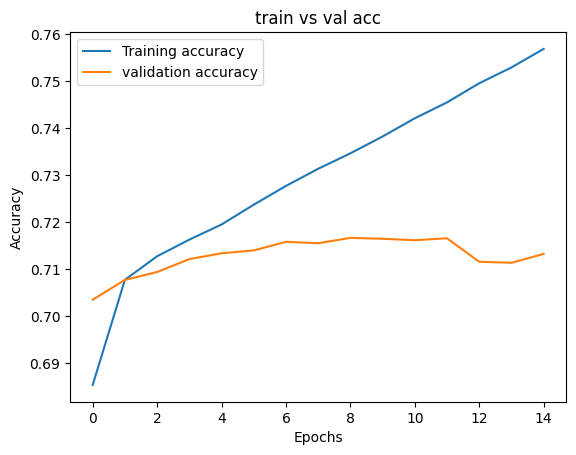

In [40]:
plt.plot(history3.history['accuracy'], label="Training accuracy")
plt.plot(history3.history['val_accuracy'], label="validation accuracy")
plt.title("train vs val acc")
plt.ylabel("Accuracy")
plt.xlabel("Epochs")
plt.legend()
plt.show()

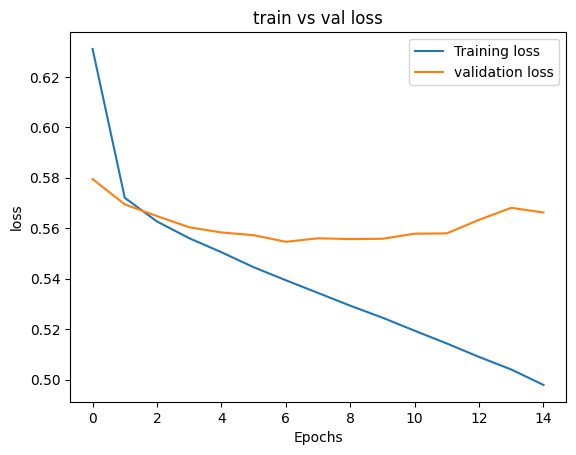

In [42]:
plt.plot(history3.history['loss'], label="Training loss")
plt.plot(history3.history['val_loss'], label="validation loss")
plt.title("train vs val loss")
plt.ylabel("loss")
plt.xlabel("Epochs")
plt.legend()
plt.show()

In [43]:
model3.evaluate(test_data)

99/99 [==============================] - 3s 33ms/step - loss: 0.5665 - accuracy: 0.7120


[0.5664972066879272, 0.712034285068512]

3159/3159 [==============================] - 14s 4ms/step


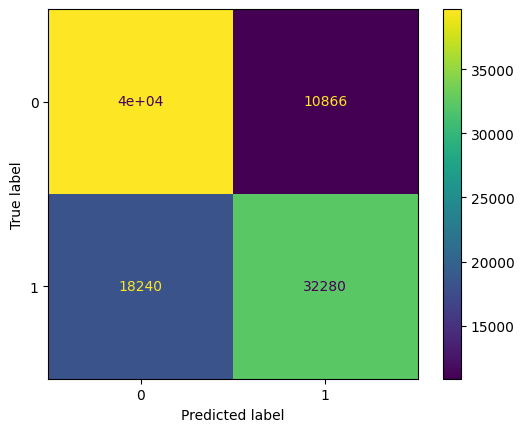

In [46]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

true_labels = test['label']
predictions = model3.predict(test['comment'])
threshold = 0.5

binary_predictions = [1 if pred > threshold else 0 for pred in predictions]
cm = confusion_matrix(true_labels, binary_predictions)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0, 1])
disp.plot()

In [47]:
from sklearn.metrics import accuracy_score, precision_score, recall_score,f1_score


accuracy = accuracy_score(true_labels, binary_predictions)
precision = precision_score(true_labels, binary_predictions)
recall = recall_score(true_labels, binary_predictions)
f1score = f1_score(true_labels, binary_predictions)

print(f"Accuracy = {accuracy.round(4)}")
print(f"Precision = {precision.round(4)}")
print(f"Recall = {recall.round(4)}")
print(f"F1 Score = {f1score.round(4)}")

Accuracy = 0.712
Precision = 0.7482
Recall = 0.639
F1 Score = 0.6893


# save model

In [ ]:
import pickle
from tensorflow.keras.models import load_model
import os


model2.save(os.path.join('models','saracasm_class'))






In [ ]:
%cd /content/models

/content/models


In [ ]:
!zip -r /content/models.zip /content/models

  adding: content/models/ (stored 0%)
  adding: content/models/saracasm_class/ (stored 0%)
  adding: content/models/saracasm_class/variables/ (stored 0%)
  adding: content/models/saracasm_class/variables/variables.data-00000-of-00001 (deflated 8%)
  adding: content/models/saracasm_class/variables/variables.index (deflated 65%)
  adding: content/models/saracasm_class/saved_model.pb (deflated 89%)
  adding: content/models/saracasm_class/fingerprint.pb (stored 0%)
  adding: content/models/saracasm_class/keras_metadata.pb (deflated 90%)
  adding: content/models/saracasm_class/assets/ (stored 0%)
  adding: content/models/DR_classification.h5 (deflated 11%)
